# Model and Evaluation

In [1]:
%pip install google-cloud
%pip install google-cloud-storage
%pip install pandas
from google.cloud import storage
import pandas as pd

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#load data_prep from cloud storage to jupyter notebook
df = pd.read_csv('gs://churn-project/data_prep.csv')

In [3]:
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,7590-VHVEG,0,0,1,0,1,0,1,29.85,...,0,0,0,0,0,0,0,0,1,0
1,1,5575-GNVDE,1,0,0,0,34,1,0,56.95,...,0,0,0,0,0,1,0,0,0,1
2,2,3668-QPYBK,1,0,0,0,2,1,1,53.85,...,0,0,0,0,0,0,0,0,0,1
3,3,7795-CFOCW,1,0,0,0,45,0,0,42.30,...,1,0,0,0,0,1,0,0,0,0
4,4,9237-HQITU,0,0,0,0,2,1,1,70.70,...,0,0,0,0,0,0,0,0,1,0


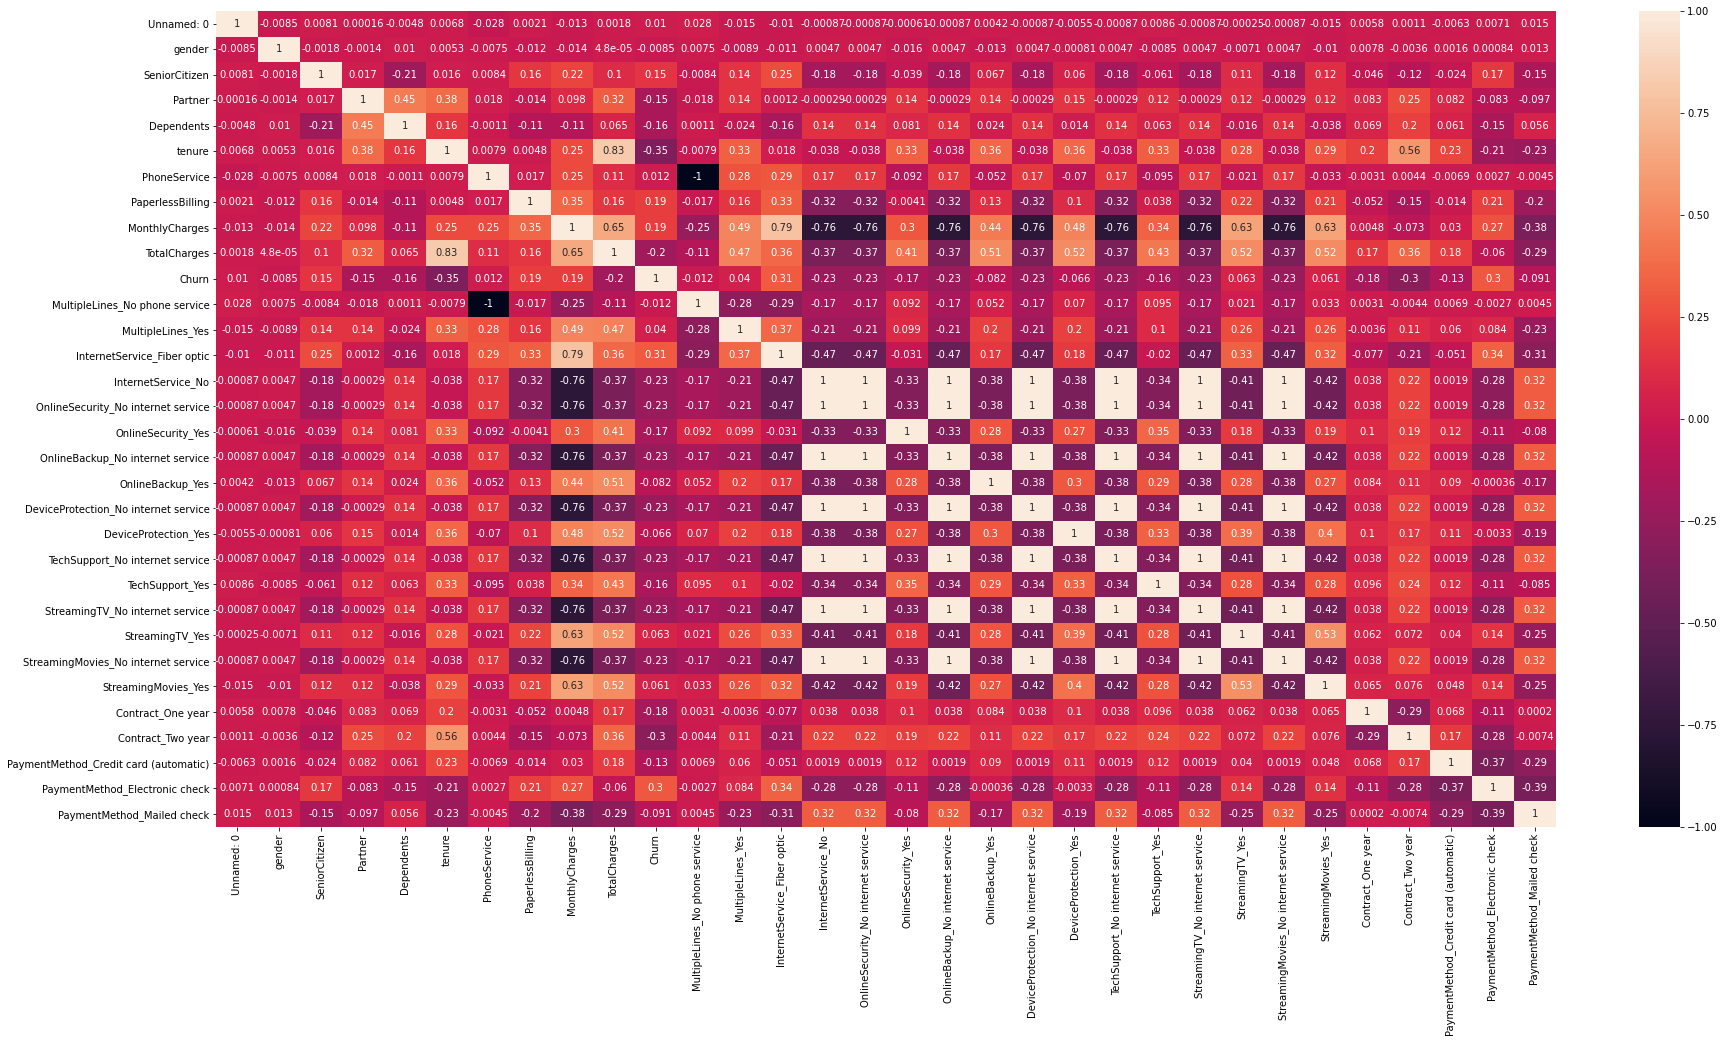

In [4]:
#create correlation plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (30,15))      
sns.heatmap(df.corr(),annot = True)
plt.show()

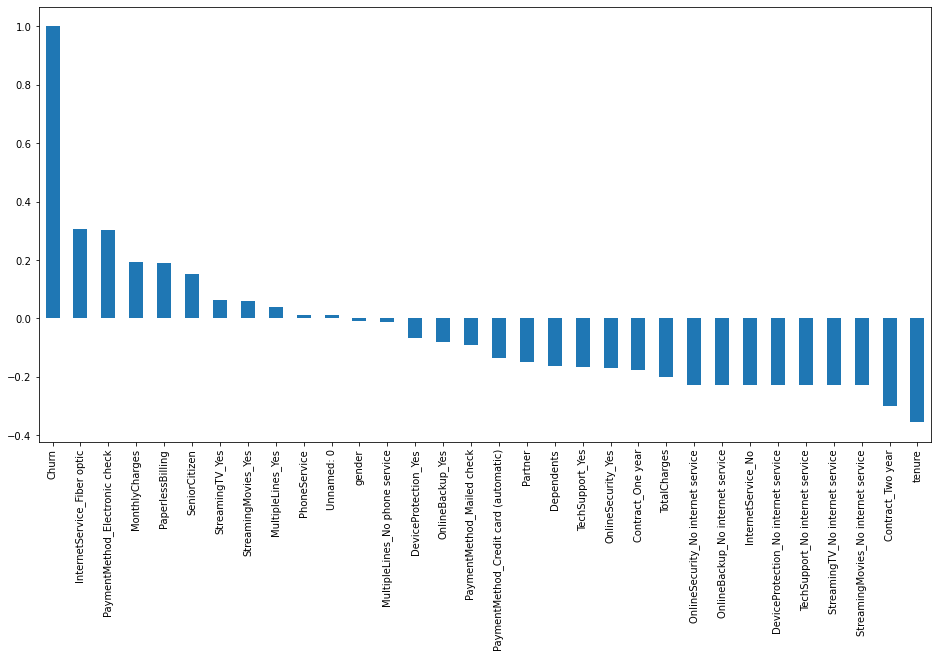

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')
plt.show()

In [6]:
import scipy.stats
# 1. gender
corr = scipy.stats.pearsonr(df.gender,df.Churn)
corr
# p-value > 0.05 

(-0.008544643224946243, 0.47373573732654467)

In [7]:
# 2. PhoneService
corr = scipy.stats.pearsonr(df.PhoneService,df.Churn)
corr
# p-value > 0.05

(0.011691398865421575, 0.32695528135874624)

In [8]:
# 3. MultipleLines_No phone service
corr = scipy.stats.pearsonr(df['MultipleLines_No phone service'],df.Churn)
corr
# p-value > 0.05

(-0.011691398865421568, 0.32695528135874624)

In [9]:
# 4. MultipleLines_Yes
corr = scipy.stats.pearsonr(df['MultipleLines_Yes'],df.Churn)
corr
# p-value < 0.05

(0.04003273987252132, 0.0007857240573236339)

In [10]:
%pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

Note: you may need to restart the kernel to use updated packages.


In [11]:
#not bring Unnamed: 0,customerID, gender, PhoneService and MultipleLines_No phone service into model 
X = df.drop(['Unnamed: 0','customerID','gender','PhoneService','MultipleLines_No phone service',
             'InternetService_No','OnlineSecurity_No internet service',
             'OnlineBackup_No internet service','DeviceProtection_No internet service',
             'TechSupport_No internet service','StreamingTV_No internet service', 
             'StreamingMovies_No internet service','Churn'] ,axis='columns')
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=20)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 3966 to 2522
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5625 non-null   int64  
 1   Partner                                5625 non-null   int64  
 2   Dependents                             5625 non-null   int64  
 3   tenure                                 5625 non-null   int64  
 4   PaperlessBilling                       5625 non-null   int64  
 5   MonthlyCharges                         5625 non-null   float64
 6   TotalCharges                           5625 non-null   float64
 7   MultipleLines_Yes                      5625 non-null   int64  
 8   InternetService_Fiber optic            5625 non-null   int64  
 9   OnlineSecurity_Yes                     5625 non-null   int64  
 10  OnlineBackup_Yes                       5625 non-null   int64  
 11  D

In [13]:
model = LogisticRegression(solver='lbfgs', max_iter=500)

In [14]:
model = LogisticRegression(solver='lbfgs', max_iter=500)
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.7982222222222223

In [15]:
metrics.confusion_matrix(y_test, model.predict(X_test))

array([[922, 120],
       [159, 206]])

In [16]:
metrics.accuracy_score(y_test, model.predict(X_test))

0.8017057569296375

In [17]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1042
           1       0.63      0.56      0.60       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.80      0.80      0.80      1407



In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif['VIF'] 

0      1.375866
1      2.833565
2      1.961732
3     15.872841
4      2.918609
5     38.515298
6     17.413823
7      2.671748
8      8.806129
9      2.162190
10     2.363046
11     2.440090
12     2.269508
13     3.158863
14     3.213663
15     1.929123
16     3.178950
17     1.853440
18     2.743710
19     1.872552
Name: VIF, dtype: float64

In [19]:
X_train.columns 

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [20]:
#drop high vif
X_train_2 = X_train.drop(['MonthlyCharges'] ,axis='columns')
X_test_2 = X_test.drop(['MonthlyCharges'] ,axis='columns')

In [21]:
model.fit(X_train_2, y_train)
model.score(X_train_2, y_train)

0.8014222222222223

In [22]:
metrics.confusion_matrix(y_test, model.predict(X_test_2))

array([[923, 119],
       [159, 206]])

In [23]:
#final model 2 
metrics.accuracy_score(y_test, model.predict(X_test_2))

0.8024164889836531

In [24]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(y_test,model.predict(X_test_2)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.63      0.56      0.60       365

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.73      1407
weighted avg       0.80      0.80      0.80      1407



In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_2.columns
vif['VIF'] = [variance_inflation_factor(X_train_2.values, i) for i in range(len(X_train_2.columns))]
vif['VIF'] 

0      1.372444
1      2.820074
2      1.947476
3     14.999978
4      2.710508
5     16.609214
6      2.356952
7      3.400177
8      1.812915
9      2.137647
10     2.241759
11     1.953781
12     2.713725
13     2.776221
14     1.928517
15     3.161289
16     1.640283
17     2.229818
18     1.414247
Name: VIF, dtype: float64

In [26]:
X_train_2.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling',
       'TotalCharges', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [27]:
#drop high vif
X_train_3 = X_train.drop(['MonthlyCharges','TotalCharges'] ,axis='columns')
X_test_3 = X_test.drop(['MonthlyCharges','TotalCharges'] ,axis='columns')

In [28]:
model.fit(X_train_3, y_train)
model.score(X_train_3, y_train)

0.8021333333333334

In [29]:
metrics.confusion_matrix(y_test, model.predict(X_test_3))

array([[922, 120],
       [161, 204]])

In [30]:
#final model 3
metrics.accuracy_score(y_test, model.predict(X_test_3))

0.8002842928216063

In [31]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(y_test,model.predict(X_test_3)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1042
           1       0.63      0.56      0.59       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407



In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_3.columns
vif['VIF'] = [variance_inflation_factor(X_train_3.values, i) for i in range(len(X_train_3.columns))]
vif['VIF'] 

0     1.368632
1     2.818457
2     1.937611
3     7.129092
4     2.655310
5     2.290586
6     2.813020
7     1.741986
8     2.004163
9     2.144156
10    1.886866
11    2.582016
12    2.634311
13    1.917666
14    3.094172
15    1.572094
16    1.992991
17    1.304793
Name: VIF, dtype: float64

In [33]:
model.intercept_

array([-0.87930902])

In [34]:
model.coef_

array([[ 0.19041693,  0.12363649, -0.21545141, -0.03649214,  0.39631337,
         0.19891966,  0.92469087, -0.1877501 , -0.02423762,  0.05508158,
        -0.28251591,  0.32714518,  0.42016308, -0.7840843 , -1.50236984,
        -0.07974597,  0.36848238, -0.11989494]])

# Feature Engineering

### 1. remove SeniorCitizen

In [35]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','SeniorCitizen'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','SeniorCitizen'] ,axis='columns')

In [36]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.7992888888888889

In [37]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[922, 120],
       [163, 202]])

In [38]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.798862828713575

In [39]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1042
           1       0.63      0.55      0.59       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     2.784018
1     1.877324
2     7.089508
3     2.640806
4     2.285777
5     2.779845
6     1.741643
7     2.002616
8     2.143937
9     1.878922
10    2.582007
11    2.633260
12    1.910788
13    3.075402
14    1.567828
15    1.967589
16    1.302265
Name: VIF, dtype: float64

### 2. remove Partner

In [41]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','Partner'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','Partner'] ,axis='columns')

In [42]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.7998222222222222

In [43]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[927, 115],
       [159, 206]])

In [44]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8052594171997157

In [45]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.64      0.56      0.60       365

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407



In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.351909
1     1.512260
2     6.741795
3     2.653782
4     2.288996
5     2.810556
6     1.741484
7     2.004144
8     2.143185
9     1.886602
10    2.581755
11    2.633152
12    1.916522
13    3.093326
14    1.571953
15    1.988825
16    1.303508
Name: VIF, dtype: float64

### 3. Remove Dependents

In [47]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','Dependents'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','Dependents'] ,axis='columns')

In [48]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8016

In [49]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[926, 116],
       [157, 208]])

In [50]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8059701492537313

In [51]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1042
           1       0.64      0.57      0.60       365

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407



In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.326049
1     2.199740
2     7.128104
3     2.654424
4     2.290384
5     2.810187
6     1.740836
7     2.004062
8     2.143501
9     1.886860
10    2.582001
11    2.632466
12    1.910086
13    3.071295
14    1.559898
15    1.978658
16    1.273495
Name: VIF, dtype: float64

### 4. remove tenure

In [53]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','tenure'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','tenure'] ,axis='columns')

In [54]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.7831111111111111

In [55]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[918, 124],
       [183, 182]])

In [56]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.7818052594171997

In [57]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1042
           1       0.59      0.50      0.54       365

    accuracy                           0.78      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.78      0.78      1407



In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.361033
1     2.665341
2     1.937342
3     2.623435
4     2.170392
5     2.800329
6     1.717170
7     1.926933
8     2.126428
9     1.885280
10    2.577981
11    2.628516
12    1.504047
13    1.882866
14    1.553425
15    1.992474
16    1.303351
Name: VIF, dtype: float64

### 5. remove PaperlessBilling

In [59]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','PaperlessBilling'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','PaperlessBilling'] ,axis='columns')

In [60]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8008888888888889

In [61]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[923, 119],
       [164, 201]])

In [62]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.798862828713575

In [63]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.63      0.55      0.59       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.361156
1     2.816836
2     1.936964
3     7.043513
4     2.286105
5     2.691747
6     1.741986
7     2.001058
8     2.144141
9     1.881682
10    2.565078
11    2.625359
12    1.914110
13    3.073426
14    1.522900
15    1.830916
16    1.235582
Name: VIF, dtype: float64

### 6. remove MultipleLines_Yes

In [65]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','MultipleLines_Yes'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','MultipleLines_Yes'] ,axis='columns')

In [66]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.7991111111111111

In [67]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[923, 119],
       [163, 202]])

In [68]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.7995735607675906

In [69]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.63      0.55      0.59       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407



In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.365758
1     2.816501
2     1.937439
3     6.755007
4     2.650115
5     2.594603
6     1.741925
7     2.003662
8     2.144135
9     1.886735
10    2.580728
11    2.629665
12    1.914519
13    3.093363
14    1.571642
15    1.991647
16    1.304784
Name: VIF, dtype: float64

### 7. remove InternetService_Fiber optic

In [71]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','InternetService_Fiber optic'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','InternetService_Fiber optic'] ,axis='columns')

In [72]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.7934222222222223

In [73]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[928, 114],
       [177, 188]])

In [74]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.7931769722814499

In [75]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1042
           1       0.62      0.52      0.56       365

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407



In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.352492
1     2.815989
2     1.935659
3     7.096929
4     2.540836
5     2.112734
6     1.738712
7     1.998406
8     2.134199
9     1.879732
10    2.534329
11    2.593570
12    1.889446
13    2.989502
14    1.562819
15    1.876012
16    1.303063
Name: VIF, dtype: float64

### 8. remove OnlineSecurity_Yes

In [77]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','OnlineSecurity_Yes'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','OnlineSecurity_Yes'] ,axis='columns')

In [78]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8019555555555555

In [79]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[920, 122],
       [163, 202]])

In [80]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.7974413646055437

In [81]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1042
           1       0.62      0.55      0.59       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.368362
1     2.817644
2     1.936332
3     7.027530
4     2.655310
5     2.290506
6     2.807732
7     1.965647
8     2.128445
9     1.806239
10    2.581695
11    2.632621
12    1.917332
13    3.093934
14    1.568600
15    1.992621
16    1.302679
Name: VIF, dtype: float64

### 9. remove OnlineBackup_Yes

In [83]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','OnlineBackup_Yes'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','OnlineBackup_Yes'] ,axis='columns')

In [84]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8016

In [85]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[923, 119],
       [160, 205]])

In [86]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8017057569296375

In [87]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.63      0.56      0.60       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.80      0.80      0.80      1407



In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.367576
1     2.818432
2     1.937513
3     6.854374
4     2.651196
5     2.290015
6     2.804940
7     1.708509
8     2.126593
9     1.859290
10    2.573142
11    2.629750
12    1.915402
13    3.071626
14    1.571952
15    1.992985
16    1.304723
Name: VIF, dtype: float64

### 10. remove DeviceProtection_Yes

In [89]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','DeviceProtection_Yes'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','DeviceProtection_Yes'] ,axis='columns')

In [90]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8019555555555555

In [91]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[922, 120],
       [159, 206]])

In [92]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8017057569296375

In [93]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1042
           1       0.63      0.56      0.60       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.80      0.80      0.80      1407



In [94]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.368493
1     2.817181
2     1.937019
3     7.070149
4     2.655292
5     2.290564
6     2.799958
7     1.729222
8     1.987747
9     1.852679
10    2.533930
11    2.567988
12    1.915199
13    3.091485
14    1.571388
15    1.992900
16    1.303657
Name: VIF, dtype: float64

### 10. remove TechSupport_Yes

In [95]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','TechSupport_Yes'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','TechSupport_Yes'] ,axis='columns')

In [96]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8

In [97]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[922, 120],
       [168, 197]])

In [98]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.7953091684434968

In [99]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1042
           1       0.62      0.54      0.58       365

    accuracy                           0.80      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF'] 

0     1.362870
1     2.818063
2     1.937604
3     7.123100
4     2.648013
5     2.290427
6     2.802384
7     1.667549
8     1.974872
9     2.105307
10    2.555705
11    2.611153
12    1.910027
13    3.065174
14    1.569916
15    1.992868
16    1.302852
Name: VIF, dtype: float64

### 11. remove StreamingTV_Yes

In [101]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','StreamingTV_Yes'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','StreamingTV_Yes'] ,axis='columns')

In [102]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8019555555555555

In [103]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[926, 116],
       [162, 203]])

In [104]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8024164889836531

In [105]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.64      0.56      0.59       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.80      0.80      0.80      1407



In [106]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF']

0     1.368628
1     2.818173
2     1.937600
3     7.117954
4     2.637892
5     2.289444
6     2.761067
7     1.741770
8     1.997275
9     2.104224
10    1.867639
11    2.332132
12    1.915906
13    3.092998
14    1.571238
15    1.989062
16    1.301933
Name: VIF, dtype: float64

### 12. remove StreamingMovies_Yes

In [107]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','StreamingMovies_Yes'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','StreamingMovies_Yes'] ,axis='columns')

In [108]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.7982222222222223

In [109]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[921, 121],
       [158, 207]])

In [110]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8017057569296375

In [111]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1042
           1       0.63      0.57      0.60       365

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.73      1407
weighted avg       0.80      0.80      0.80      1407



In [112]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF']

0     1.368086
1     2.817217
2     1.936254
3     7.113408
4     2.646286
5     2.286546
6     2.769514
7     1.740869
8     2.000692
9     2.090172
10    1.870278
11    2.285835
12    1.916895
13    3.093787
14    1.572087
15    1.985801
16    1.303649
Name: VIF, dtype: float64

### 13. remove Contract_One year

In [113]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','Contract_One year'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','Contract_One year'] ,axis='columns')

In [114]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8024888888888889

In [115]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[931, 111],
       [172, 193]])

In [116]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.798862828713575

In [117]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1042
           1       0.63      0.53      0.58       365

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF']

0     1.363723
1     2.816776
2     1.929952
3     5.591427
4     2.650387
5     2.286827
6     2.771624
7     1.741683
8     2.001796
9     2.141397
10    1.879350
11    2.579645
12    2.633252
13    2.144371
14    1.559579
15    1.992776
16    1.267903
Name: VIF, dtype: float64

### 14. remove Contract_Two year

In [119]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','Contract_Two year'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','Contract_Two year'] ,axis='columns')

In [120]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8023111111111111

In [121]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[930, 112],
       [169, 196]])

In [122]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8002842928216063

In [123]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.64      0.54      0.58       365

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407



In [124]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF']

0     1.360330
1     2.817687
2     1.923285
3     4.338198
4     2.637506
5     2.289988
6     2.717861
7     1.741852
8     1.989560
9     2.142294
10    1.869183
11    2.581037
12    2.633984
13    1.329010
14    1.565192
15    1.987763
16    1.280557
Name: VIF, dtype: float64

### 15. remove PaymentMethod_Credit card(automatic)

In [125]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','PaymentMethod_Credit card (automatic)'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','PaymentMethod_Credit card (automatic)'] ,axis='columns')

In [126]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8016

In [127]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[923, 119],
       [158, 207]])

In [128]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8031272210376688

In [129]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.63      0.57      0.60       365

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.73      1407
weighted avg       0.80      0.80      0.80      1407



In [130]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF']

0     1.364918
1     2.818205
2     1.922578
3     7.044432
4     2.572218
5     2.289927
6     2.796423
7     1.738115
8     2.003981
9     2.143192
10    1.884252
11    2.580609
12    2.634299
13    1.902400
14    3.080588
15    1.772330
16    1.218958
Name: VIF, dtype: float64

### 16. remove PaymentMethod_Electronic check

In [131]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','PaymentMethod_Electronic check'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','PaymentMethod_Electronic check'] ,axis='columns')

In [132]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.7998222222222222

In [133]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[926, 116],
       [162, 203]])

In [134]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8024164889836531

In [135]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1042
           1       0.64      0.56      0.59       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.80      0.80      0.80      1407



In [136]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF']

0     1.351188
1     2.812567
2     1.923677
3     7.127244
4     2.439374
5     2.289042
6     2.647909
7     1.741664
8     2.004157
9     2.144058
10    1.886750
11    2.576926
12    2.624808
13    1.917460
14    3.086056
15    1.398034
16    1.239419
Name: VIF, dtype: float64

### 17. remove PaymentMethod_Mailed check

In [137]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','PaymentMethod_Mailed check'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','PaymentMethod_Mailed check'] ,axis='columns')

In [138]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.8017777777777778

In [139]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[921, 121],
       [160, 205]])

In [140]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8002842928216063

In [141]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1042
           1       0.63      0.56      0.59       365

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407



In [142]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF']

0     1.365981
1     2.815682
2     1.891134
3     7.121214
4     2.514462
5     2.290571
6     2.809291
7     1.739164
8     2.004055
9     2.142288
10    1.884058
11    2.576355
12    2.632002
13    1.863449
14    3.036699
15    1.468675
16    1.893136
Name: VIF, dtype: float64

### final model

In [143]:
X_train_4 = X_train.drop(['MonthlyCharges','TotalCharges','Partner','Dependents','OnlineBackup_Yes','DeviceProtection_Yes','StreamingTV_Yes','StreamingMovies_Yes','Contract_Two year',
                          'PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check','PaymentMethod_Mailed check'] ,axis='columns')
X_test_4 = X_test.drop(['MonthlyCharges','TotalCharges','Partner','Dependents','OnlineBackup_Yes','DeviceProtection_Yes','StreamingTV_Yes','StreamingMovies_Yes','Contract_Two year',
                          'PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check','PaymentMethod_Mailed check'] ,axis='columns')

In [144]:
model.fit(X_train_4, y_train)
model.score(X_train_4, y_train)

0.7962666666666667

In [145]:
metrics.confusion_matrix(y_test, model.predict(X_test_4))

array([[937, 105],
       [172, 193]])

In [146]:
metrics.accuracy_score(y_test, model.predict(X_test_4))

0.8031272210376688

In [147]:
model.intercept_

array([-0.92609316])

In [148]:
model.coef_

array([[ 0.39920641, -0.04334066,  0.58704007,  0.26476369,  1.37991358,
        -0.19858917, -0.27232593, -0.42169448]])

In [149]:
print(classification_report(y_test,model.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1042
           1       0.65      0.53      0.58       365

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.80      1407



In [150]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(len(X_train_4.columns))]
vif['VIF']

0    1.293039
1    3.027538
2    2.258015
3    2.275567
4    2.263504
5    1.672532
6    1.698767
7    1.302224
Name: VIF, dtype: float64

In [151]:
X_train_4.columns

Index(['SeniorCitizen', 'tenure', 'PaperlessBilling', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'Contract_One year'],
      dtype='object')